# 04: Basis expansion


Let's start in 1D: consider an interval $[a,b]$ with a mesh over it, that is
$$
a = x_1 < x_2 < \ldots < x_{N_v-1} < x_{N_v} = b
$$
with trivial connectivity list.

One thing we could do is to consider the space of the functions that are piecewise linear on the elements:
$$
P_{[a,b]}
=
\biggl\{
\varphi \in C[a,b] \,:\, \varphi|_{[x_i,x_{i+1}]} = \text{ a linear }, \,\, i = 1,2,\ldots,N_v
\biggr\}
$$

Any member $s$ of this space can be written as the linear combination
$$
s(x) = \sum_{i=1}^{N_v} c_i \varphi_i(x)
$$
where $\varphi_1, \varphi_2, \ldots, \varphi_{N_v}$ are the linear hat functions
$$
\varphi_i(x) = 
\begin{cases}
\displaystyle\frac{x - x_{i-1}}{x_{i}-x_{i-1}} & \text{$x \in [ x_{i-1},x_i ]$} \\
\\
\displaystyle\frac{x_{i+1} - x}{x_{i+1}-x_{i}} & \text{$x \in [ x_{i},x_{i+1}]$} \\
\end{cases}
$$
(where $x_0=x_1$ and $x_{N_v+1}=x_{N_v}$ when needed) that form a basis for $P_{[a,b]}$. The dimension of this space is therefore $N_v$ (as the number of hat functions forming the basis). 


Here in the following we plot some.

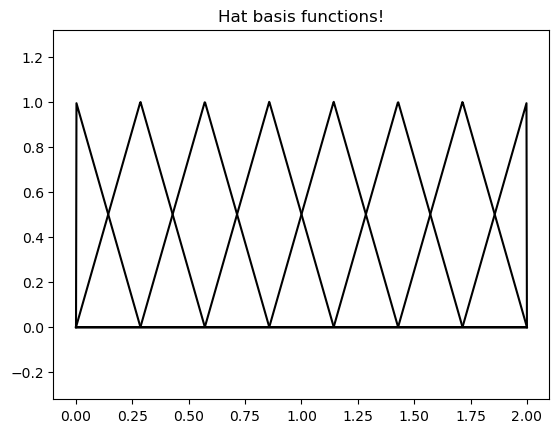

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

a = 0
b = 2
Nv = 8
x = np.linspace( a,b,Nv )

augx = np.hstack((x[0],x,x[-1]))


fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')
xx = np.linspace( a,b,1000 )
for i in range( 1, Nv+1 ):
    yy = np.zeros( xx.shape )
    
    id = np.argwhere( (xx > augx[i-1]) & (xx < augx[i]) )
    yy[ id ] = ( xx[ id ] - augx[ i-1 ] ) / ( augx[ i ] - augx[ i-1 ] )
    
    id = np.argwhere( (xx > augx[i]) & (xx < augx[i+1]) )
    yy[ id ] = ( augx[ i+1 ] - xx[ id ] ) / ( augx[ i+1 ] - augx[ i ] )
    
    plt.plot( xx, yy, 'k' )

plt.title('Hat basis functions!')
plt.show()


By noticing that $s(x_i) = c_i$ it is extremely easy for us to interpolate a function! It is enough to set $c_i = f(x_i)$ for some choice of $f$.

In the following we set $f(x) = \sin( \pi x)$ and try different ways to plot the result. 


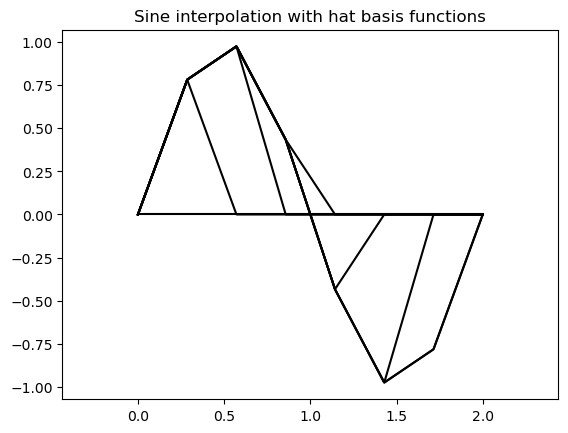

In [2]:
fun = lambda x : np.sin( x * np.pi )

# evaluation of the function at the augmented sequence
c = fun( augx )

fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')
xx = np.linspace( a,b,1000 )
yy = np.zeros( xx.shape )
for i in range( 1, Nv+1 ):
    
    id = np.argwhere( (xx > augx[i-1]) & (xx < augx[i]) )
    yy[ id ] = yy[ id ] + c[ i ] * ( xx[ id ] - augx[ i-1 ] ) / ( augx[ i ] - augx[ i-1 ] )
    
    id = np.argwhere( (xx > augx[i]) & (xx < augx[i+1]) )
    yy[ id ] = yy[ id ] + c[ i ] * ( augx[ i+1 ] - xx[ id ] ) / ( augx[ i+1 ] - augx[ i ] )
    
    plt.plot( xx, yy, 'k' )

plt.title('Sine interpolation with hat basis functions')
plt.show()

Clearly this is an expensive procedure, also, it requires to handle extreme points in a special way.

This is even more dramatic when in higher dimension. There, in fact, hat functions are formed by a variable/unforeseeable number of branches (see picture).

We can and we should do better! To do so we must switch perspective from vertices to elements.
In each element, in fact, there will always be $d+1$ branches of the hat functions.

For example, in 1D, in the $k$th element there will be the descending branch of the hat function centered at the left extreme of the element and the ascending branch of the hat function centered at the right extreme.



In [3]:
Nv = 8

Points = np.linspace( a,b,Nv )[:,None]
CList  = np.vstack((np.arange( 0,Points.shape[0]-1 ), np.arange( 1,Points.shape[0]-1+1 ) )).T
B      = np.transpose( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:], ( 0, 2, 1 ) )
dtB    = np.linalg.det( B ) # ofc this is dumb in 1D


phi = lambda x: np.array([ 1 - x, x ])

# these are in the reference element
points_in_refelem        = np.linspace( 0, 1, 100 )
# these are the 2 branches evaluated on the reference element
phi_of_points_in_refelem = phi( points_in_refelem ) 
# these are in the physical elements
points_in_phyelem        = (B @ points_in_refelem[None,:]).reshape(Nv-1,-1) + Points[CList[:,0]] 
# evaluation of the function at vertices
c = fun( Points ).reshape(-1)

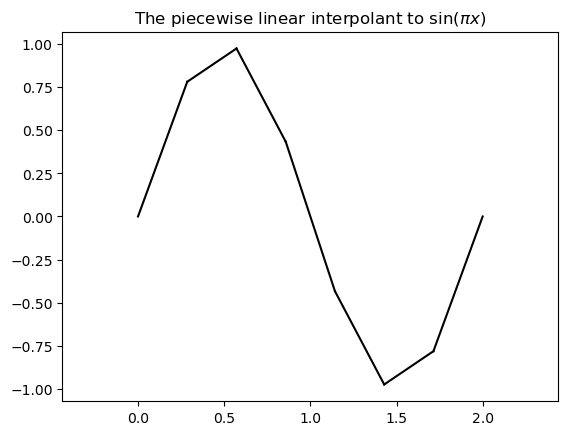

In [4]:
# this is a better way
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')
for k in range( Nv - 1 ):
    plt.plot( points_in_phyelem[k], c[ CList[k,:] ] @ phi_of_points_in_refelem, 'k' )
plt.title('The piecewise linear interpolant to $\sin(\pi x)$')
plt.show()

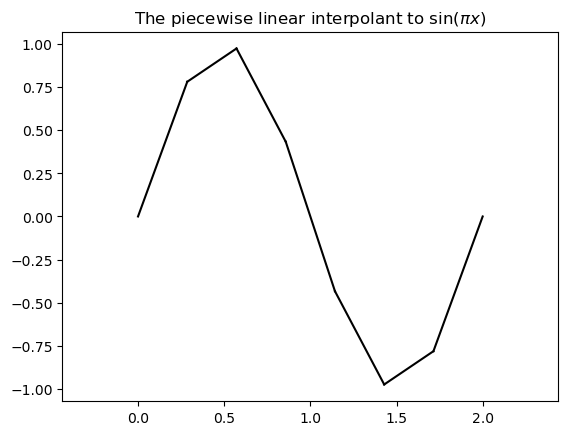

In [5]:
# we can be go faster
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.plot( points_in_phyelem.T, (c[CList] @ phi_of_points_in_refelem).T, 'k' )
plt.title('The piecewise linear interpolant to $\sin(\pi x)$')
plt.show()

Plotting served as an excuse for presenting this technique which is, in fact, a procedure allowing for massive parallel evaluations at ''twin'' locations to locations in the reference element.

Evaluations instead at ''untracked'' locations, that is, locations that we do not know how to map into reference location is much harder. In particular, the hard part is finding the physical element containing a certain point $p$. Once we have this information we know how to move freely from the physical to the reference element.


### Remark

Even though
$$
s(x) = \sum_{i=1}^{N_v}f(x_i)\varphi_i(x)
$$
is a perfect approximation to $f$ at vertices, obviously this does not mean that it is as good in the elements' interiors (see next figure).

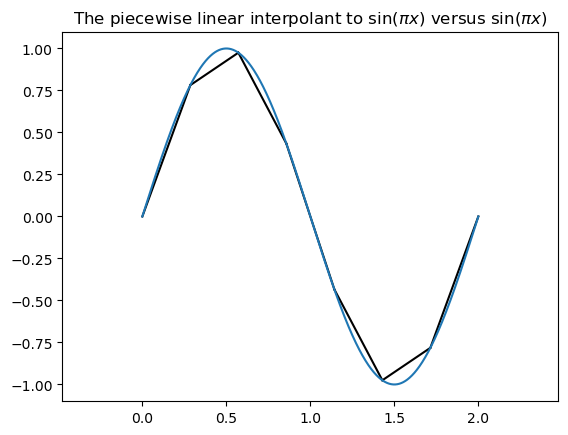

In [6]:
# we can be go faster
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')

plt.plot( points_in_phyelem.T, (c[CList] @ phi_of_points_in_refelem).T, 'k' )
xx = np.linspace( a,b, 1000 )
plt.plot( xx, fun(xx) )
plt.title('The piecewise linear interpolant to $\sin(\pi x)$ versus $\sin(\pi x)$')
plt.show()

How do we measure this difference? Of course by computing the $L_2$ norm of their difference using quadrature :)

In [7]:
def simplexQuadrature( N, D ):

        def rquad( N, d ):
            #
            cof = 2 * np.array( range( N ) ) + d
            if d:
                A = ( d ** 2 ) / ( cof * ( cof + 2 ) )
            else:
                A = np.zeros( N )
            B = ( cof[1:] ** 2 - d ** 2 ) / ( 2 * cof[1:] * np.sqrt( cof[1:]**2 - 1 ) )
            M = np.diag( A ) + np.diag( B, -1 ) + np.diag( B, 1 )
            #
            x, V = np.linalg.eig( M )
            i = np.argsort( x )
            x = ( x[ i ] + 1 ) / 2
            w = V[ 0,i ]**2 / ( d + 1 )
            return x, w
        #
        X = np.ones( ( N ** D, D + 1 ) )
        W = np.ones( ( N ** D, ) )
        dim = np.ones( D, dtype = 'int32' )
        dim[0] = -1
        for d in range( 1, D + 1 ):
            # cornerstone of this implementation
            x, w = rquad( N, D - d )
            # some auxiliary arrays
            transposition = np.array( range( D ), dtype = 'int32' )
            transposition[ d - 1 ] = 0
            transposition[ 0 ] = d - 1
            tilation = np.ones( D, dtype = 'int32' ) * N
            tilation[ d - 1 ] = 1
            # create the structures you need
            x = np.transpose( x.reshape( dim ), transposition )
            w = np.transpose( w.reshape( dim ), transposition )
            # build X and W
            X[ :,d ] = X[ :,d-1 ] * np.tile( x, tilation ).reshape( -1, order = 'F' )
            W        = W          * np.tile( w, tilation ).reshape( -1, order = 'F' )

        # manipulate output
        X = - np.diff( X,1,1 )
        permutation = np.roll( np.array( range( D ), dtype = 'int32' ),1 )
        X = X[:,permutation]

        return X, W

In [8]:
Nv = 8

Points = np.linspace( a,b,Nv )[:,None]
CList  = np.vstack((np.arange( 0,Points.shape[0]-1 ), np.arange( 1,Points.shape[0]-1+1 ) )).T
B      = np.transpose( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:], ( 0, 2, 1 ) )
dtB    = np.linalg.det( B ) # ofc this is dumb in 1D

c = fun( Points ).reshape(-1)

X, W = simplexQuadrature( N = 3, D = 1 )
res = 0
for q in range(W.size):
    p = B @ X[q,:] + Points[CList[:,0]]
    z = fun( p ) - c[CList] @ phi( X[q,:] )
    res = res + z[:,None]**2 * W[q] * dtB[:,None]
absoluteL2error = np.sum( np.sqrt( res ) )

res = 0
for q in range(W.size):
    p = B @ X[q,:] + Points[CList[:,0]]
    z = fun( p )
    res = res + z[:,None]**2 * W[q] * dtB[:,None]
normL2f = np.sqrt( np.sum( res ) )

relativeL2error = absoluteL2error / normL2f 

print( relativeL2error )

0.45275572632591987


Let's now play in higher dimension!

In [9]:
import meshio 
import matplotlib.pyplot as plt


# handle mesh thingy
mesh = meshio.read('../mesh-files/crown.vtu')
Points = mesh.points[:,:2]  # for sake of brevity
CList  = mesh.cells[0].data # for sake of brevity
B   = np.transpose( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:], ( 0,2,1 ) )
dtB = np.linalg.det( B )

# define function of crown section and evaluate coefficients
r = 1
R = 2
#fun = lambda p: np.sin( np.arccos( p[:,0] / np.sqrt( np.sum( p**2,1 ) ) ) ) \
#              * np.cos( np.arccos( p[:,0] / np.sqrt( np.sum( p**2,1 ) ) ) ) \
#              * ( np.sqrt( np.sum( p**2,1 ) ) - r ) * ( R - np.sqrt( np.sum( p**2,1 ) ) )
fun = lambda p: np.sin( np.arccos( p[0] / np.sqrt( np.sum( p**2,1 ) ) ) ) \
              * np.cos( np.arccos( p[0] / np.sqrt( np.sum( p**2,1 ) ) ) ) \
              * ( np.sqrt( np.sum( p**2,1 ) ) - r ) * ( R - np.sqrt( np.sum( p**2,1 ) ) )
# approximation coefficients
Points.shape )
c = fun( Points )

# phi now has 3 branches: one for each vertex of each triangular element
phi = lambda p: np.array([ 1 - p[:,0] - p[:,1], p[:,0], p[:,1] ])


X, W = simplexQuadrature( N = 3, D = 2 )


res = 0
for q in range(W.size):
    p = B @ X[q,:] + Points[CList[:,0]]
    z = fun( p ) - c[CList] @ phi( X[q,:][None,:] )
    res = res + z[:,None]**2 * W[q] * dtB[:,None]
absoluteL2error = np.sqrt( np.sum( res ) )

res = 0
for q in range(W.size):
    p = B @ X[q,:] + Points[CList[:,0]]
    z = fun( p )
    res = res + z[:,None]**2 * W[q] * dtB[:,None]
normL2f = np.sqrt( np.sum( res ) )

res = 0
for q in range(W.size):
    p = B @ X[q,:] + Points[CList[:,0]]
    z = c[CList] @ phi( X[q,:][None,:] )
    res = res + z[:,None]**2 * W[q] * dtB[:,None]
normL2s = np.sqrt( np.sum( res ) )


relativeL2error = absoluteL2error / normL2f 

print( relativeL2error )
print( absoluteL2error )

print( normL2f )
print( normL2s )

#print( (c[CList] @ phi( X[q,:][None,:] )).shape )
#print( (c[CList]).shape )
#print( (phi( X[q,:][None,:] )).shape )
#print( z.shape )
#print( c[CList[k,:]] )
#print( c.shape )
#print( Points.shape )
#print( c[CList].shape )

ValueError: operands could not be broadcast together with shapes (2,) (44,) 